In [1]:
import json
import os
from os.path import join
import ast

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.mplot3d import axes3d    
import plotly.graph_objects as go
import numpy as np
from scipy.spatial.transform import Rotation as R
from pytransform3d.transformations import plot_transform
from pytransform3d.plot_utils import make_3d_axis


%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
QUERY_NAME = 'query_00'
OPTIMIZER = 'teaser'

query_name = QUERY_NAME
query_dir = f'../../datasets/{query_name}'
query_images_dir = join(query_dir, 'images')
query_imagenames_filepath = join(query_dir, f'{query_name}_imagenames.txt')

keypoints_dir = f'../result/{query_name}/keypoints/patchnetvlad_superpoint_superglue'
keypoints_filenames = os.listdir(keypoints_dir)

matches_image_dir = f'../3rd/SuperGluePretrainedNetwork/dump_match_pairs'

results_filepath = f'../result/{query_name}/pose_optimization/PNTR_{OPTIMIZER}.json'
transformations_filepath = f'../result/{query_name}/pose_optimization/transformations_{OPTIMIZER}.json'

gt_query_poses_filepath = f'../../datasets/{query_name}/poses.json'
gt_db_poses_filepath = f'../../datasets/database/poses.json'

assert os.path.exists(query_dir)
assert os.path.exists(query_images_dir)
assert os.path.isfile(query_imagenames_filepath)
assert os.path.exists(keypoints_dir)
assert len(keypoints_filenames) > 0
assert os.path.exists(matches_image_dir)
assert os.path.isfile(results_filepath)
assert os.path.isfile(transformations_filepath)
assert os.path.isfile(gt_query_poses_filepath)
assert os.path.isfile(gt_db_poses_filepath)

In [5]:
CAMERA_INTRINSICS = {'query_00': [859.7086033959424, 859.7086033959424, 
                                  559.0216447990299, 309.07840227628515],
                     'query_01': [867.1920188938037, 867.1920188938037, 
                                  554.9548231998494, 308.58383552157835],
                     'query_17': [830.93694071386, 830.93694071386, 
                                  572.169579679035, 309.80029849197297],
                     'database': [830.93694071386, 830.93694071386, 
                                  572.169579679035, 309.80029849197297]
                    }

MAX_DEPTH_DISTANCE = 100  # иначе выбросы сильно мешают визуализации


def cloud_3d_cam(x, y, depth, fx, fy, cx, cy):
    if depth <= 0:
        return 0
    new_x = depth  # roll
    new_y = (x - cx)*depth/fx  # pitch
    new_z = (y - cy)*depth/fy  # yaw
    coord_3D_world_to_cam = np.array([new_x, new_y, new_z], float)
    return coord_3D_world_to_cam


def points_to_3d(points_dict, query_name):
    query_3d_points = []
    db_3d_points = []
    
    q_fx, q_fy, q_cx, q_cy = CAMERA_INTRINSICS[query_name]
    db_fx, db_fy, db_cx, db_cy = CAMERA_INTRINSICS['database']
    
    dict_keys = list(points_dict.keys())
    query_num = query_name.split('_')[-1]
    if dict_keys[0].startswith(query_num):
        query_key = dict_keys[0]
        db_key = dict_keys[1]
    else:
        query_key = dict_keys[1]
        db_key = dict_keys[0]
    for query_point in points_dict[query_key]:
        q_x, q_y, q_depth = query_point
        if q_depth > 0 and q_depth < MAX_DEPTH_DISTANCE:
            query_3d_point = cloud_3d_cam(q_x, q_y, q_depth,
                                          q_fx, q_fy, q_cx, q_cy)
            query_3d_points.append(query_3d_point)
    for db_point in points_dict[db_key]:
        db_x, db_y, db_depth = db_point
        if db_depth > 0 and db_depth < MAX_DEPTH_DISTANCE:
            db_3d_point = cloud_3d_cam(db_x, db_y, db_depth,
                                       db_fx, db_fy, db_cx, db_cy)
            db_3d_points.append(db_3d_point)
    
    query_3d_points = np.array(query_3d_points)
    db_3d_points = np.array(db_3d_points)
    
    return query_3d_points.T, db_3d_points.T

# Read data

In [6]:
# Set this to query image index 
CURRENT_QUERY_IDX = np.random.randint(0, len(keypoints_filenames))
CURRENT_QUERY_IDX = 146

# mismatches found file visualizing
image_retrieval_mismatches = []

print(f"\nCURRENT QUERY INDEX (RANDOMIZED): {CURRENT_QUERY_IDX}")


CURRENT QUERY INDEX (RANDOMIZED): 146


In [7]:
query_imagenames_list = []
with open(query_imagenames_filepath) as f:
    for line in f.readlines():
        query_imagenames_list.append(line.split('/')[-1].split('.')[0])
query_imagenames_list.sort()

query_imagename = query_imagenames_list[CURRENT_QUERY_IDX]
print(f"Current query image: {query_imagename}")

keypoints_filename = [filename for filename in keypoints_filenames \
                      if filename.startswith(query_imagename)][0]
db_imagename = keypoints_filename.split('_')[-1].split('.')[0]
matches_image_filename = f"{query_name}_images_{query_imagename}"\
                         +f"_database_images_{db_imagename}_matches.png"

print(f"Matched db image filename: {db_imagename}")
print(f"Matches image filename: {matches_image_filename}")
print(f"Keypoints filename: {keypoints_filename}")

with open(join(keypoints_dir, keypoints_filename)) as f:
    keypoints_str = json.load(f)
    ast.literal_eval(keypoints_str)  
    keypoints_dict = ast.literal_eval(keypoints_str)
    
print(f"query keypoints matches {len(keypoints_dict[list(keypoints_dict.keys())[0]])}")
print(f"database keypoints matches {len(keypoints_dict[list(keypoints_dict.keys())[1]])}")
query_points, db_points = points_to_3d(keypoints_dict, query_name)

print("\n3D keypoints in query:", query_points.shape[1])
print("3D keypoints in database ref image:", db_points.shape[1])

with open(transformations_filepath) as f:
    transformation_4x4 = np.array(json.load(f)[query_imagename])
    
print("\nTransformation 4x4 matrix (found by TEASER++):")
print(transformation_4x4)

print("\nInverse transformation matrix:")
print(np.linalg.inv(transformation_4x4))

Current query image: 00track00000820
Matched db image filename: 15track00003660
Matches image filename: query_00_images_00track00000820_database_images_15track00003660_matches.png
Keypoints filename: 00track00000820_15track00003660.json
query keypoints matches 286
database keypoints matches 286

3D keypoints in query: 277
3D keypoints in database ref image: 276

Transformation 4x4 matrix (found by TEASER++):
[[ 0.99932426 -0.01021504 -0.0353082   1.95536079]
 [ 0.01091043  0.99974918  0.0195586   6.38123438]
 [ 0.03509956 -0.01993061  0.99918506 -1.34601074]
 [ 0.          0.          0.          1.        ]]

Inverse transformation matrix:
[[ 0.99932426  0.01091043  0.03509956 -1.97641713]
 [-0.01021504  0.99974918 -0.01993061 -6.38648656]
 [-0.0353082   0.0195586   0.99918506  1.28914612]
 [ 0.          0.          0.          1.        ]]


# Matched pair image

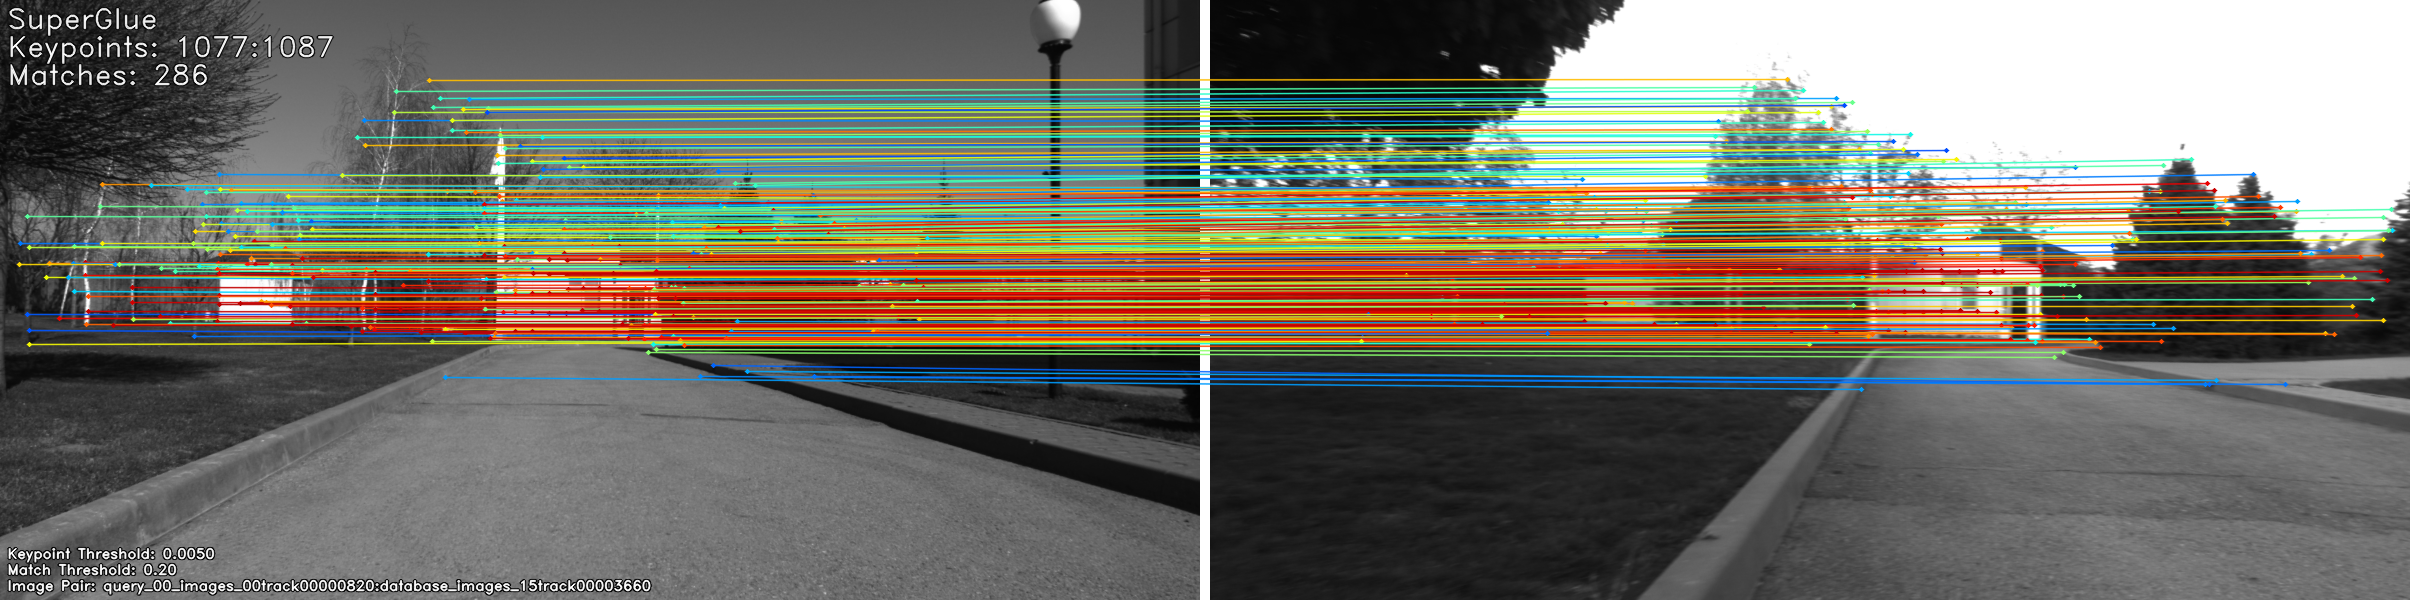

In [8]:
image = Image.open(join(matches_image_dir, matches_image_filename))
image.show()

# Transformation estimation relative to camera

In [10]:
def visualize_relative_transformation(relative_query_points, relative_db_points,
                                      transformation):
    q_x = np.squeeze(relative_query_points[0, :])
    q_y = np.squeeze(relative_query_points[1, :])
    q_z = np.squeeze(relative_query_points[2, :])

    db_x = np.squeeze(relative_db_points[0, :])
    db_y = np.squeeze(relative_db_points[1, :])
    db_z = np.squeeze(relative_db_points[2, :])
    
    size = relative_db_points.shape[1]
    points_estimation = np.append(relative_db_points, np.ones((1,size)), axis = 0)
    points_estimation = np.matmul(transformation, points_estimation)
    x_est, y_est, z_est = points_estimation[:3,:]
    
    fig = go.Figure(data=[go.Scatter3d(x=x_est, y=y_est, z=z_est,
                                       mode='markers', name = 'Estimation',
                                       marker=dict(size=4, color='black',
                                                   colorscale='Viridis', opacity=1)), 
                          go.Scatter3d(x=db_x, y=db_y, z=db_z,
                                       mode='markers', name = 'Mapping (Database)',
                                       marker=dict(size=4, color='red',
                                                   colorscale='Viridis', opacity=0.5)),
                          go.Scatter3d(x=q_x, y=q_y, z=q_z,
                                       mode='markers', name = 'Query',
                                       marker=dict(size=4, color='blue',
                                                   colorscale='Viridis', opacity=0.5))],)
    fig.update_layout(title="Plot 3D")
    fig.show()
    
    
visualize_relative_transformation(query_points, db_points, transformation_4x4)

# Pose estimation

In [11]:
with open(gt_query_poses_filepath) as f:
    gt_query_pose_dict = json.load(f)[query_imagename]
    gt_query_pose_4x4 = np.eye(4)
    gt_query_pose_orientation_quat = [gt_query_pose_dict['orientation'][1],
                                      gt_query_pose_dict['orientation'][2],
                                      gt_query_pose_dict['orientation'][3],
                                      gt_query_pose_dict['orientation'][0]]
    gt_query_pose_4x4[:3, :3] = R.from_quat(gt_query_pose_orientation_quat).as_matrix()
    gt_query_pose_4x4[:3, 3] = gt_query_pose_dict['position']
    
with open(gt_db_poses_filepath) as f:
    gt_db_pose_dict = json.load(f)[db_imagename]
    gt_db_pose_4x4 = np.eye(4)
    gt_db_pose_orientation_quat = [gt_db_pose_dict['orientation'][1],
                                   gt_db_pose_dict['orientation'][2],
                                   gt_db_pose_dict['orientation'][3],
                                   gt_db_pose_dict['orientation'][0]]
    gt_db_pose_4x4[:3, :3] = R.from_quat(gt_db_pose_orientation_quat).as_matrix()
    gt_db_pose_4x4[:3, 3] = gt_db_pose_dict['position']

print("Ground truth query pose:")
print(gt_query_pose_4x4)
print("\nDatabase match pose:")
print(gt_db_pose_4x4)

baseline_error_pose = np.linalg.inv(gt_db_pose_4x4) @ gt_query_pose_4x4
baseline_dist_error = np.sum(baseline_error_pose[:3, 3]**2) ** 0.5
baseline_r = R.from_matrix(baseline_error_pose[:3, :3])
baseline_rotvec = baseline_r.as_rotvec()
baseline_angle_error = (np.sum(baseline_rotvec**2)**0.5) * 180 / 3.14159265353
baseline_angle_error = abs(90 - abs(baseline_angle_error-90))

print("\nBaseline (without optimization):")
print("\tPosition difference: ", gt_query_pose_4x4[:3, 3] - gt_db_pose_4x4[:3, 3])
print("\tDistance error:", baseline_dist_error)
print("\tAngle error:", baseline_angle_error)
print()

estimated_pose_4x4 =  gt_db_pose_4x4 @ np.linalg.inv(transformation_4x4)

print("\nEstimated pose:")
print(estimated_pose_4x4)

error_pose = np.linalg.inv(estimated_pose_4x4) @ gt_query_pose_4x4
dist_error = np.sum(error_pose[:3, 3]**2) ** 0.5
r = R.from_matrix(error_pose[:3, :3])
rotvec = r.as_rotvec()
angle_error = (np.sum(rotvec**2)**0.5) * 180 / 3.14159265353
angle_error = abs(90 - abs(angle_error-90))

print("\nOptimization results:")
print("\tPosition difference: ", gt_query_pose_4x4[:3, 3] - estimated_pose_4x4[:3, 3])
print("\tDistance error:", dist_error)
print("\tAngle error:", angle_error)

Ground truth query pose:
[[ 8.79365647e-01 -4.76122887e-01 -4.80171520e-03  4.92971676e+05]
 [ 4.76145947e-01  8.79340983e-01  6.66875664e-03  5.23440775e+06]
 [ 1.04719731e-03 -8.15059273e-03  9.99966235e-01  3.49618988e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Database match pose:
[[ 7.98496662e-01 -6.01985216e-01 -4.10862642e-03  4.92974285e+05]
 [ 6.01994419e-01  7.98498980e-01  1.44884293e-03  5.23441032e+06]
 [ 2.40855198e-03 -3.63026641e-03  9.99990510e-01  3.49961548e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Baseline (without optimization):
	Position difference:  [-2.60923882 -2.57713349 -0.03425598]
	Distance error: 3.667549278065785
	Angle error: 8.583693261558736


Estimated pose:
[[ 8.04251462e-01 -5.93202641e-01  3.59195316e-02  4.92976546e+05]
 [ 5.93379771e-01  8.04895058e-01  6.66283005e-03  5.23440404e+06]
 [-3.28638618e-02  1.59553326e-02  9.99332474e-01  3.63037130e+01]
 [ 0.00000000e+00  0.00000000e+00 

In [12]:
print(np.linalg.inv(gt_db_pose_4x4) @ gt_query_pose_4x4)
print(transformation_4x4)

[[ 9.88810258e-01  1.49156198e-01  2.58887138e-03 -3.63497097e+00]
 [-1.49166868e-01  9.88801406e-01  4.58541310e-03 -4.86990909e-01]
 [-1.87593688e-03 -4.92027734e-03  9.99986136e-01 -2.72691304e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 0.99932426 -0.01021504 -0.0353082   1.95536079]
 [ 0.01091043  0.99974918  0.0195586   6.38123438]
 [ 0.03509956 -0.01993061  0.99918506 -1.34601074]
 [ 0.          0.          0.          1.        ]]


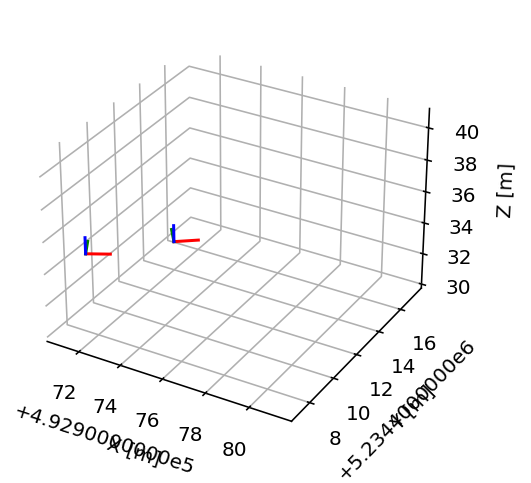

In [15]:
ax = make_3d_axis(ax_s=1, unit="m", n_ticks=6)
ax.set_xlim(gt_query_pose_4x4[0,3]-1, gt_query_pose_4x4[0,3]+10)
ax.set_ylim(gt_query_pose_4x4[1,3]-1, gt_query_pose_4x4[1,3]+10)
ax.set_zlim(gt_query_pose_4x4[2,3]-5, gt_query_pose_4x4[2,3]+6)
plot_transform(ax=ax, A2B=gt_query_pose_4x4)
plot_transform(ax=ax, A2B=gt_db_pose_4x4)
# plot_transform(ax=ax, A2B=estimated_pose_4x4)
plt.show()

# Points transformation visualization

## Visualization of query and database points in absolute coordinates

In [ ]:
def rel_to_abs(points, abs_pose):
    size = points.shape[1]
    abs_points = np.append(points, np.ones((1,size)), axis = 0)
    abs_points = np.matmul(abs_pose, abs_points)
    return abs_points[:3, :]


def visualize_abs_q_and_db(relative_query_points, relative_db_points):
    abs_query_points = rel_to_abs(relative_query_points, gt_query_pose_4x4)
    abs_db_points = rel_to_abs(relative_db_points, gt_db_pose_4x4)
    
    q_x = np.squeeze(abs_query_points[0, :])
    q_y = np.squeeze(abs_query_points[1, :])
    q_z = np.squeeze(abs_query_points[2, :])

    db_x = np.squeeze(abs_db_points[0, :])
    db_y = np.squeeze(abs_db_points[1, :])
    db_z = np.squeeze(abs_db_points[2, :])
    
    fig = go.Figure(data=[go.Scatter3d(x=db_x, y=db_y, z=db_z,
                                       mode='markers', name = 'Mapping (Database)',
                                       marker=dict(size=4, color='red',
                                                   colorscale='Viridis', opacity=0.5)),
                          go.Scatter3d(x=q_x, y=q_y, z=q_z,
                                       mode='markers', name = 'Query',
                                       marker=dict(size=4, color='blue',
                                                   colorscale='Viridis', opacity=0.5))],)
    fig.update_layout(title="Plot 3D")
    fig.show()


visualize_abs_q_and_db(query_points, db_points)

## Visualization of transformation

In [ ]:
def visualize_absolute_transformation(relative_query_points, relative_db_points,
                                      transformation):
    abs_query_points = rel_to_abs(relative_query_points, gt_query_pose_4x4)
    abs_db_points = rel_to_abs(relative_db_points, gt_db_pose_4x4)
    
    q_x = np.squeeze(abs_query_points[0, :])
    q_y = np.squeeze(abs_query_points[1, :])
    q_z = np.squeeze(abs_query_points[2, :])

    db_x = np.squeeze(abs_db_points[0, :])
    db_y = np.squeeze(abs_db_points[1, :])
    db_z = np.squeeze(abs_db_points[2, :])
    
    size = abs_db_points.shape[1]
    points_estimation = np.append(abs_db_points, np.ones((1,size)), axis = 0)
    points_estimation = np.matmul(transformation, points_estimation)
    x_est, y_est, z_est = points_estimation[:3,:]
    
    fig = go.Figure(data=[
                          go.Scatter3d(x=x_est, y=y_est, z=z_est,
                                       mode='markers', name = 'Estimation',
                                       marker=dict(size=4, color='black',
                                                   colorscale='Viridis', opacity=1)), 
#                           go.Scatter3d(x=db_x, y=db_y, z=db_z,
#                                        mode='markers', name = 'Mapping (Database)',
#                                        marker=dict(size=4, color='red',
#                                                    colorscale='Viridis', opacity=0.5)),
#                           go.Scatter3d(x=q_x, y=q_y, z=q_z,
#                                        mode='markers', name = 'Query',
#                                        marker=dict(size=4, color='blue',
#                                                    colorscale='Viridis', opacity=0.5))
                         ],)
    fig.update_layout(title="Plot 3D")
    fig.show()

visualize_absolute_transformation(query_points, db_points, transformation_4x4)